In [36]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, ReLU, Add, AveragePooling2D, Flatten, Dense
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model

In [ ]:
# Загрузка данных
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

y_train = y_train.flatten()
y_test = y_test.flatten()

# Разделение на тренировочные и валидационные данные
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

# Предобработка данных (нормализация)
x_train = x_train / 255.0
x_val = x_val / 255.0
x_test = x_test / 255.0
datagen = ImageDataGenerator(
    rotation_range=15,  # Вращение изображения в пределах 15 градусов
    width_shift_range=0.1,  # Сдвиг изображения по ширине на 10% от ширины
    height_shift_range=0.1,  # Сдвиг изображения по высоте на 10% от высоты
    horizontal_flip=True,  # Горизонтальное отражение изображения
    zoom_range=0.1,  # Увеличение изображения на 10%
)


In [ ]:
def residual_block(x, filters, kernel_size=3, stride=1):
    y = Conv2D(filters, kernel_size=kernel_size, strides=stride, padding='same')(x)
    y = BatchNormalization()(y)
    y = ReLU()(y)

    y = Conv2D(filters, kernel_size=kernel_size, padding='same')(y)
    y = BatchNormalization()(y)

    if stride > 1:
        x = Conv2D(filters, kernel_size=1, strides=stride, padding='same')(x)
        x = BatchNormalization()(x)

    return Add()([x, y])


In [ ]:
def build_resnet(input_shape, num_classes, num_blocks_list):
    assert len(num_blocks_list) == 4, "The number of blocks list should have 4 values."

    input_layer = Input(shape=input_shape)
    x = Conv2D(64, kernel_size=7, strides=2, padding='same')(input_layer)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = AveragePooling2D(pool_size=3, strides=2, padding='same')(x)

    for i, num_blocks in enumerate(num_blocks_list):
        for j in range(num_blocks):
            stride = 2 if i > 0 and j == 0 else 1
            x = residual_block(x, filters=64 * (2**i), stride=stride)

    x = Flatten()(x)
    output_layer = Dense(num_classes, activation='softmax')(x)

    model = tf.keras.Model(inputs=input_layer, outputs=output_layer)
    return model


In [ ]:
input_shape = (32, 32, 3)  # Размер входных изображений
num_classes = 10  # Количество классов (можно изменить на нужное)
num_blocks_list = [3, 4, 6, 3]  # Количество блоков в каждом из 4-х этапов

resnet_model = build_resnet(input_shape, num_classes, num_blocks_list)


In [ ]:
# Предполагается, что y_train и y_val уже являются одномерными массивами целых чисел
# Важно, чтобы классы начинались с 0 и шли по порядку, например, 0, 1, 2, ..., 9

# Компиляция модели
resnet_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


# Обучение модели
batch_size = 64
epochs = 20

history = resnet_model.fit(
    datagen.flow(x_train, y_train, batch_size=batch_size),
    steps_per_epoch=len(x_train) / batch_size,
    epochs=epochs,
    validation_data=(x_val, y_val)
)

# Оценка точности на тестовых данных
test_loss, test_accuracy = resnet_model.evaluate(x_test, y_test)
print(f'Test Accuracy: {test_accuracy}')


Epoch 1/20
625/625 [==============================] - 64s 69ms/step - loss: 1.8100 - accuracy: 0.3822 - val_loss: 2.4541 - val_accuracy: 0.2222
Epoch 2/20
625/625 [==============================] - 40s 64ms/step - loss: 1.4715 - accuracy: 0.4791 - val_loss: 2.2419 - val_accuracy: 0.3019
Epoch 3/20
625/625 [==============================] - 40s 63ms/step - loss: 1.3478 - accuracy: 0.5267 - val_loss: 1.8890 - val_accuracy: 0.4362
Epoch 4/20
625/625 [==============================] - 40s 64ms/step - loss: 1.2979 - accuracy: 0.5487 - val_loss: 1.4660 - val_accuracy: 0.5128
Epoch 5/20
625/625 [==============================] - 40s 64ms/step - loss: 1.2280 - accuracy: 0.5733 - val_loss: 1.5063 - val_accuracy: 0.5029
Epoch 6/20
625/625 [==============================] - 42s 67ms/step - loss: 1.0890 - accuracy: 0.6219 - val_loss: 1.3224 - val_accuracy: 0.5626
Epoch 7/20
625/625 [==============================] - 39s 62ms/step - loss: 1.0461 - accuracy: 0.6363 - val_loss: 1.1652 - val_accuracy:

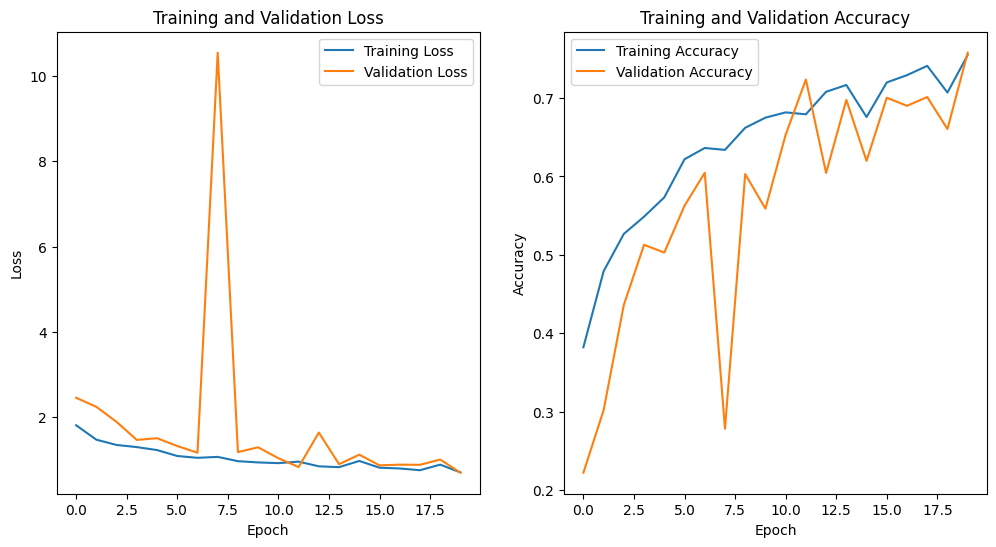

In [ ]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

# Построение графика потерь
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Построение графика точности
plt.subplot(1, 2, 2)
plt.plot(train_accuracy, label='Training Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [37]:
# Сохранение модели
resnet_model.save('resnet_model.h5')

# Загрузка модели
#loaded_model = load_model('resnet_model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 1s 1s/step


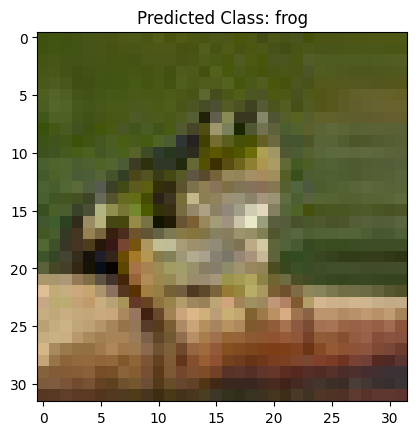

In [35]:
# Загрузка обученной модели
# (Вставьте код загрузки вашей обученной модели, если она не была загружена ранее)

# Загрузка изображения для проверки
img_path = 'path_to_your_image.jpg'  # Замените 'path_to_your_image.jpg' на путь к вашему изображению
img = image.load_img(img_path, target_size=(32, 32))  # Предполагается, что модель обучалась на изображениях 32x32

# Преобразование изображения в массив numpy
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)  # Добавление дополнительной размерности для batch

# Нормализация изображения
img_array /= 255.0

# Предсказание класса
predictions = resnet_model.predict(img_array)

# Получение индекса класса с наибольшей вероятностью
predicted_class_index = np.argmax(predictions)

# Загрузка словаря классов CIFAR-10
class_labels = [
    'airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'
]

# Вывод изображения
plt.imshow(img)
plt.title(f"Predicted Class: {class_labels[predicted_class_index]}")
plt.show()